# What turn does Quasar Rogue pop off?

In [ ]:
import numpy as np
import pandas as pd
import random
import copy
import matplotlib.pyplot as plt
import time

# Build a deck from a list of cards.
# (It's just a list, we're not fancy enough for classes here)
def build_deck(components):
    deck = []
    for key in components:
        deck.extend([key] * components[key])
    return deck


# This is our deck!
deck = build_deck({"quasar": 2, "quick pick": 2, "knickknack":2, "prep": 2, "x": 22})


# Simulate a game of Hearthstone
# --------------------------------------------------
def sim_game(
        deck,
        coin=None,                  # Are you going second
        mulligan_strategy="hard",   # 'hard' mulligan strategy only wants Quasar and Prep. 'soft' will keep a location or a weapon
        quasar_cost=6,              # You can nerf it, if you want
        verbose=True
    ):

    # Set up some variables we'll track through the game
    # --------------------------------------------------
    turn = 0
    hand = []
    weapon = 0
    location = []                # list of locations on the board
    location_waiting_for = []    # list of remaining turns for locations on the board
                                 # we're not going to reactivate the location by playing the card drawn from it, that's hard to code
    if coin is None:
        coin = bool(np.random.randint(2))
    starting_hand_size = 3 + coin
    if verbose:
        if coin:
            print("You go second")
        else:
            print("You go first")

    # Draw your initial hand
    # --------------------------------------------------
    for d in range(starting_hand_size):
        deck, hand = draw(deck, hand, verbose=verbose)
    
    # Mulligan
    # --------------------------------------------------
    if verbose:
        print(f"Before mulligan: {hand}")

    # the cards we mulligan depend on our strategy:
    if mulligan_strategy == "hard":
        none_of_list = ["knickknack", "quick pick", "x"]
        one_of_list = ["quasar", "prep"]
    else:
        none_of_list = ["x"]
        one_of_list = ["quasar", "prep", "knickknack", "quick pick"]

    to_mulligan = []
    for cardname in none_of_list:
        while cardname in hand:
            to_mulligan.append(cardname)
            hand.remove(cardname)
    for cardname in one_of_list:
        while hand.count(cardname) > 1:
            to_mulligan.append(cardname)
            hand.remove(cardname)

    for _ in to_mulligan:
        deck, hand = draw(deck, hand, verbose=verbose)
    for card in to_mulligan:
        deck.append(card)

    if verbose:
        print(f"Mulliganning: {to_mulligan}")
        print(f"After mulligan: {hand}")
    assert(len(hand) == starting_hand_size)
    assert(len(deck) == 30 - starting_hand_size)

    # Add the coin to your hand. *Ting!*
    # --------------------------------------------------
    if coin:
        hand = ["coin"] + hand

    if verbose:
        print(f"Game start:")


    # Loop through turns until we play Quasar
    # --------------------------------------------------
    while True:
        # Update a number of status trackers
        # --------------------------------------------------
        turn = turn + 1
        if verbose:
            print("turn " + str(turn))
            print(f"hand: {hand}")
        already_attacked = False
        location_waiting_for = [max(0, n - 1) for n in location_waiting_for]  # Count down reopening timers on locations on the board
        mana = min([turn, 10])

        # Draw a card
        deck, hand = draw(deck, hand, verbose=verbose)

        # Player actions
        # --------------------------------------------------
    
        # The loop below ranks the actions available to the player in priority order. This is the gameplay strategy.
        # Each time the player takes an action, the hand, deck and board update and the loop resets.
        # The turn ends when the player plays Quasar or can't do another action
        while True:
            # With prep and coin we can discount Quasar
            # Remember: prep THEN coin
            mana_bonus = 2 * ("prep" in hand) + ("coin" in hand)

            # Play quasar if we can
            # --------------------------------------------------
            # In reality this might be more complicated: maybe you want to wait a turn if your hand is good and it will help you pop off
            # It's maybe not not suuper likely. if you had a location or a weapon you'd have probably already played it
            if "quasar" in hand and mana >= quasar_cost - mana_bonus:
                if verbose:
                    print("  QUASARRR")
                mana = mana - quasar_cost + mana_bonus
                # Now we check: is this a pop-off? i.e. can you draw a card after playing Quasar?
                # Is a weapon equipped?
                if weapon > 0:
                    return {'turns': turn, 'pop-off': True}
                # Is a location open?
                for i, (loc, wait) in enumerate(zip(location, location_waiting_for)):
                    if loc > 0 and wait == 0:
                        return {'turns': turn, 'pop-off': True}
                # Can we play a weapon?
                if "quick pick" in hand and mana >= 2:
                    return {'turns': turn, 'pop-off': True}
                # Can we play a location?
                if "knickknack" in hand and mana >= 3:
                    return {'turns': turn, 'pop-off': True}
                # Nope? Then it's not a pop-off
                return {'turns': turn, 'pop-off': False}
    
            # Attack  with weapon
            # --------------------------------------------------
            # But if we know we can play Quasar next turn we'll hold back
            if not ("quasar" in hand and turn + 1 + mana_bonus >= quasar_cost):
                if weapon > 0 and already_attacked == False:
                    if verbose:
                        print("  attacking!")
                    deck, hand = draw(deck, hand, verbose=verbose)
                    already_attacked = True
                    weapon = weapon - 1
                    continue

            # Play weapon if it'll leave us enough mana to play quasar if we draw it
            # ----------------------------------------------------------------------
            if "quick pick" in hand and weapon == 0:
                if mana >= quasar_cost + 2 - mana_bonus:
                    _ = hand.remove("quick pick")
                    mana = mana - 2
                    weapon = 2
                    if verbose:
                        print("  playing quick pick")
                    continue

            # Use location(s)
            # --------------------------------------------------
            # But if we know we can play Quasar next turn we'll keep it open to pop off
            used_a_location = False
            if not ("quasar" in hand and turn + 1 + mana_bonus >= quasar_cost):
                for i, (loc, wait) in enumerate(zip(location, location_waiting_for)): 
                    if loc > 0 and wait == 0:
                        if verbose:
                            print(f"  using location {i}")
                        deck, hand = draw(deck, hand, verbose=verbose)
                        location_waiting_for[i] = 2
                        location[i] = loc - 1
                        used_a_location = True
                        break
                if used_a_location:
                    location_waiting_for = [wait for loc, wait in zip(location, location_waiting_for) if loc > 0]
                    location = [loc for loc in location if loc > 0]
                    continue

            # Play a weapon
            # --------------------------------------------------
            # We'll choose to do this before playing a location because it guarantees us draws on the next two turns
            # Not everyone would make this choice, maybe you'd prefer to play and expensive location if you can and the weapon next turn
            if "quick pick" in hand and mana >= 2 and weapon == 0:
                _ = hand.remove("quick pick")
                mana = mana - 2
                weapon = 2
                if verbose:
                    print("  playing quick pick")
                continue

            # Play a location
            # --------------------------------------------------
            if "knickknack" in hand and mana >= 3:
                _ = hand.remove("knickknack")
                mana = mana - 3
                location.append(4)
                location_waiting_for.append(0)
                if verbose:
                    print("  playing location")
                continue

            # If we somehow reached fatigue, throw an error.
            # --------------------------------------------------
            if len(deck) == 0:
                raise ValueError("fatigue??")

            # End the turn if there wasn't anything we could do
            # --------------------------------------------------
            break


# Draw from a deck and update your hand and deck
def draw(deck, hand, i=None, verbose=True):
    if not deck:
        if verbose:
            print("  fatigue!!")
        return deck, hand

    if i is None:
        i = random.choice(range(len(deck)))

    card_drawn = deck.pop(i)
    if card_drawn != "x":
        if verbose:
            print("  drew " + card_drawn)
    hand.append(card_drawn)

    return deck, hand

In [2]:
# simulate one game
sim_game(copy.deepcopy(deck), mulligan_strategy="hard", quasar_cost=6, verbose=True)

You go second
  drew prep
Before mulligan: ['prep', 'x', 'x', 'x']
  drew quick pick
Mulliganning: ['x', 'x', 'x']
After mulligan: ['prep', 'x', 'x', 'quick pick']
Game start:
turn 1
hand: ['coin', 'prep', 'x', 'x', 'quick pick']
turn 2
hand: ['coin', 'prep', 'x', 'x', 'quick pick', 'x']
  drew quasar
  playing quick pick
  attacking!
turn 3
hand: ['coin', 'prep', 'x', 'x', 'x', 'quasar', 'x']
  QUASARRR


{'turns': 3, 'pop-off': True}

In [3]:
n_sims = 1000000

results = {
    "Going first, hard mulligan for prep + quasar":
    [sim_game(copy.deepcopy(deck), coin=False, mulligan_strategy="hard", quasar_cost=6, verbose=False) for sim in range(n_sims)],
    "Going second, hard mulligan for prep + quasar":
    [sim_game(copy.deepcopy(deck), coin=True, mulligan_strategy="hard", quasar_cost=6, verbose=False) for sim in range(n_sims)],
    "Going first, keeping draw in mulligan":
    [sim_game(copy.deepcopy(deck), coin=False, mulligan_strategy="soft", quasar_cost=6, verbose=False) for sim in range(n_sims)],
    "Going second, keeping draw in mulligan":
    [sim_game(copy.deepcopy(deck), coin=True, mulligan_strategy="soft", quasar_cost=6, verbose=False) for sim in range(n_sims)],
    "Going first, hard mulligan for prep + quasar. Quasar costs 7":
    [sim_game(copy.deepcopy(deck), coin=False, mulligan_strategy="hard", quasar_cost=7, verbose=False) for sim in range(n_sims)],
    "Going second, hard mulligan for prep + quasar. Quasar costs 7":
    [sim_game(copy.deepcopy(deck), coin=True, mulligan_strategy="hard", quasar_cost=7, verbose=False) for sim in range(n_sims)],
    "Going first, keeping draw in mulligan. Quasar costs 7":
    [sim_game(copy.deepcopy(deck), coin=False, mulligan_strategy="soft", quasar_cost=7, verbose=False) for sim in range(n_sims)],
    "Going second, keeping draw in mulligan. Quasar costs 7":
    [sim_game(copy.deepcopy(deck), coin=True, mulligan_strategy="soft", quasar_cost=7, verbose=False) for sim in range(n_sims)]
}

for key, sim in results.items():
    df = pd.DataFrame(sim)
    df = df.value_counts(sort=False).unstack(fill_value=0).stack().reset_index()
    df.columns = ['turns', 'pop-off', 'count']
    df['percentage'] = 100 * df['count'] / df['count'].sum()
    df['turns'] = df['turns'].astype(int)
    results[key] = df
    

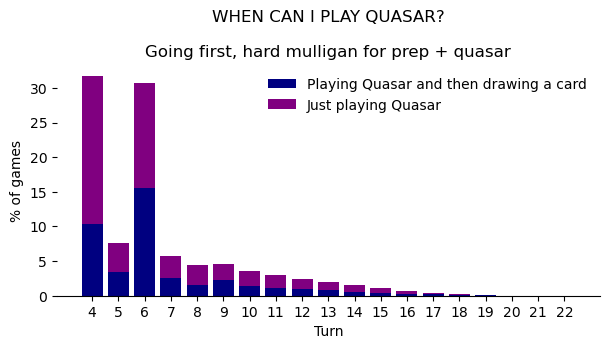

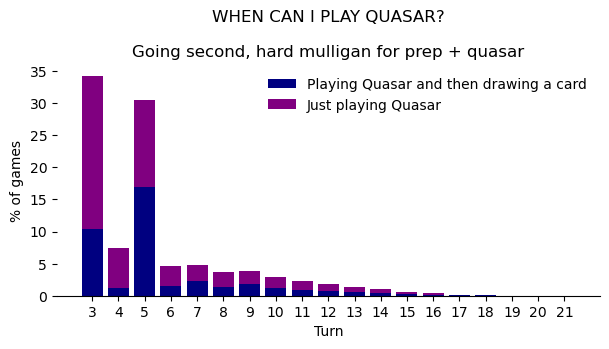

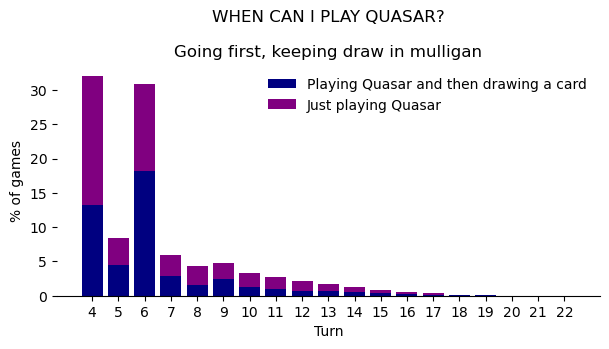

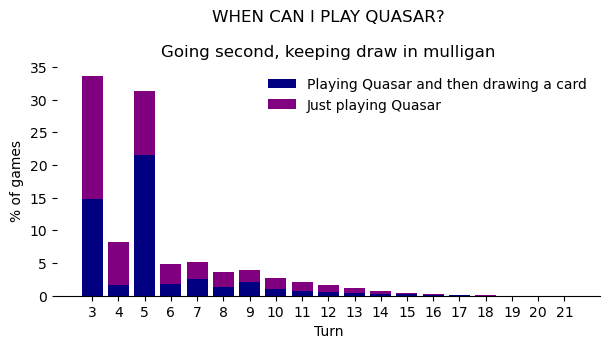

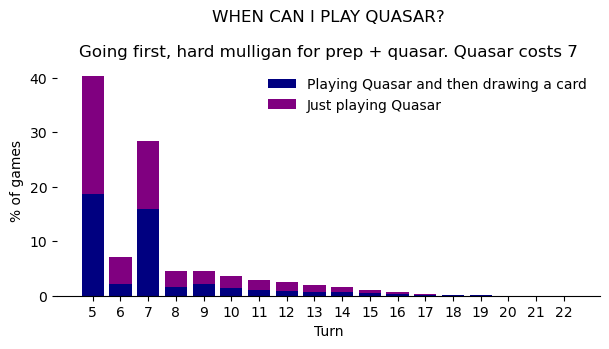

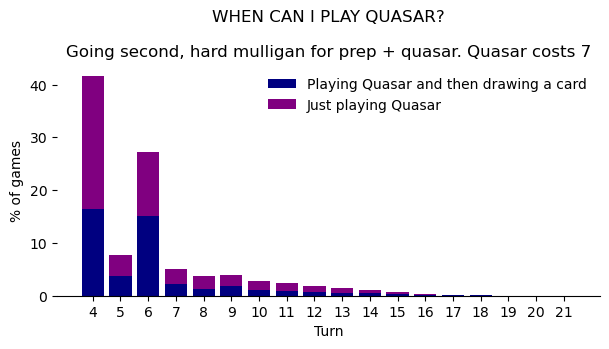

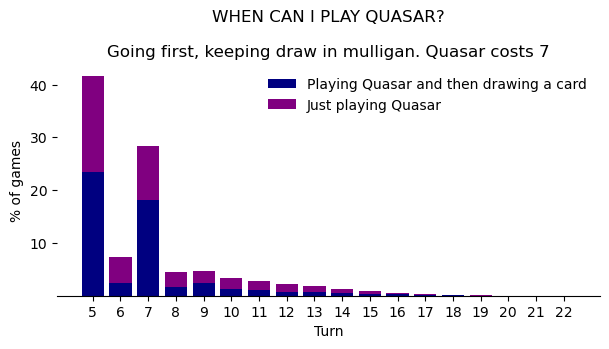

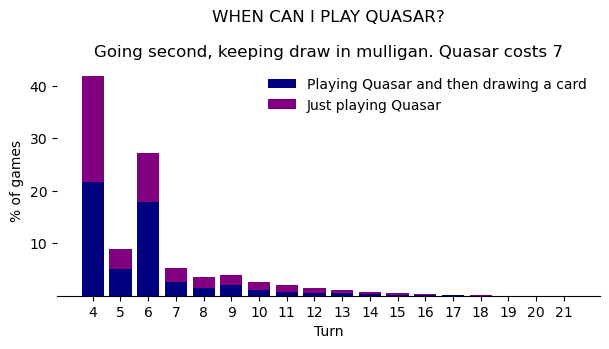

In [4]:
for key, df in results.items():
    f, ax = plt.subplots(figsize=(7, 3))
    popoff = df[df['pop-off']]
    notoff = df[~df['pop-off']]
    ax.bar(popoff['turns'], popoff['percentage'], color='navy', label='Playing Quasar and then drawing a card')
    ax.bar(notoff['turns'], notoff['percentage'], bottom=popoff['percentage'], color='purple', label='Just playing Quasar')
    ax.set_xlabel("Turn")
    ax.set_ylabel("% of games")
    # ax.get_yaxis().set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    ax.set_title(f"WHEN CAN I PLAY QUASAR?\n\n{key}")
    ax.legend(edgecolor='none')
    ax.set_xticks(np.unique(popoff['turns']))